In [ ]:
# CELDA 1: INSTALACIÓN Y CONFIGURACIÓN INICIAL
print("🔧 CONFIGURACIÓN DEL ENTORNO COLAB")
print("="*60)

# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix)

# Para algoritmos genéticos (implementación propia)
import random

print("✅ Librerías importadas correctamente")
print("✅ Entorno configurado para experimentación")

🔧 CONFIGURACIÓN DEL ENTORNO COLAB
✅ Librerías importadas correctamente
✅ Entorno configurado para experimentación


In [ ]:
#============================================================================
# CELDA 2: CARGA Y ANÁLISIS EXPLORATORIO DEL DATASET
# ============================================================================

print("\n" + "="*60)
print("📊 CARGA Y ANÁLISIS DEL DATASET WISCONSIN")
print("="*60)

# Cargar dataset
data = load_breast_cancer()
X = data.data
y = data.target

print(f"📋 INFORMACIÓN GENERAL:")
print(f"• Muestras: {X.shape[0]}")
print(f"• Características: {X.shape[1]}")
print(f"• Clases: {data.target_names}")

# Distribución de clases
unique, counts = np.unique(y, return_counts=True)
print(f"\n📊 DISTRIBUCIÓN DE CLASES:")
for i, (clase, count) in enumerate(zip(data.target_names, counts)):
    print(f"• {clase}: {count} ({count/len(y)*100:.1f}%)")

# Mostrar características
print(f"\n🧬 CARACTERÍSTICAS DEL DATASET:")
for i, feature in enumerate(data.feature_names[:10]):
    print(f"  {i+1:2d}. {feature}")
print(f"  ... y {len(data.feature_names)-10} más")



📊 CARGA Y ANÁLISIS DEL DATASET WISCONSIN
📋 INFORMACIÓN GENERAL:
• Muestras: 569
• Características: 30
• Clases: ['malignant' 'benign']

📊 DISTRIBUCIÓN DE CLASES:
• malignant: 212 (37.3%)
• benign: 357 (62.7%)

🧬 CARACTERÍSTICAS DEL DATASET:
   1. mean radius
   2. mean texture
   3. mean perimeter
   4. mean area
   5. mean smoothness
   6. mean compactness
   7. mean concavity
   8. mean concave points
   9. mean symmetry
  10. mean fractal dimension
  ... y 20 más


In [ ]:
#============================================================================
# CELDA 3: PREPROCESAMIENTO ESTÁNDAR PARA TODOS LOS MÉTODOS
# ============================================================================

print("\n" + "="*60)
print("🔧 PREPROCESAMIENTO ESTÁNDAR")
print("="*60)

# División estratificada (80/20) - MISMA PARA TODOS LOS MÉTODOS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📂 DIVISIÓN DE DATOS:")
print(f"• Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"• Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Estandarización aplicada (μ=0, σ=1)")

# Verificar estandarización
print(f"📊 VERIFICACIÓN DE ESTANDARIZACIÓN:")
print(f"• Media entrenamiento: {X_train_scaled.mean():.4f}")
print(f"• Desviación estándar: {X_train_scaled.std():.4f}")



🔧 PREPROCESAMIENTO ESTÁNDAR
📂 DIVISIÓN DE DATOS:
• Entrenamiento: 455 muestras (80.0%)
• Prueba: 114 muestras (20.0%)
✅ Estandarización aplicada (μ=0, σ=1)
📊 VERIFICACIÓN DE ESTANDARIZACIÓN:
• Media entrenamiento: -0.0000
• Desviación estándar: 1.0000


In [ ]:
#============================================================================
# CELDA 4: DEFINICIÓN DE FUNCIONES AUXILIARES
# ============================================================================

def evaluate_model(model, X_test, y_test, model_name, training_time):
    """Función para evaluar consistentemente todos los modelos"""

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Resultados
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'training_time': training_time,
        'confusion_matrix': cm,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

    return results

def print_results(results):
    """Función para imprimir resultados de manera consistente"""
    print(f"\n📊 RESULTADOS - {results['model_name'].upper()}")
    print(f"• Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    print(f"• Precision: {results['precision']:.4f}")
    print(f"• Recall: {results['recall']:.4f}")
    print(f"• F1-Score: {results['f1_score']:.4f}")
    print(f"• AUC-ROC: {results['auc_roc']:.4f}")
    print(f"• Tiempo: {results['training_time']:.4f}s")
    print(f"• Matriz: TP={results['tp']}, TN={results['tn']}, FP={results['fp']}, FN={results['fn']}")


In [ ]:
#============================================================================
# CELDA 5: IMPLEMENTACIÓN 1 - REGRESIÓN LOGÍSTICA
# ============================================================================

print("\n" + "="*60)
print("🧠 MÉTODO 1: REGRESIÓN LOGÍSTICA (CONVEXO)")
print("="*60)

# Optimización de hiperparámetros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

print("⚙️ Optimizando hiperparámetros...")
start_time = time.time()

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr, cv=5, scoring='f1', n_jobs=-1
)
grid_lr.fit(X_train_scaled, y_train)

# Entrenar modelo final
best_lr = grid_lr.best_estimator_
training_time_lr = time.time() - start_time

print(f"✅ Mejores parámetros: {grid_lr.best_params_}")
print(f"✅ F1-Score CV: {grid_lr.best_score_:.4f}")

# Evaluar
results_lr = evaluate_model(best_lr, X_test_scaled, y_test, "Regresión Logística", training_time_lr)
print_results(results_lr)



🧠 MÉTODO 1: REGRESIÓN LOGÍSTICA (CONVEXO)
⚙️ Optimizando hiperparámetros...
✅ Mejores parámetros: {'C': 0.1, 'solver': 'lbfgs'}
✅ F1-Score CV: 0.9845

📊 RESULTADOS - REGRESIÓN LOGÍSTICA
• Accuracy: 0.9737 (97.37%)
• Precision: 0.9726
• Recall: 0.9861
• F1-Score: 0.9793
• AUC-ROC: 0.9957
• Tiempo: 0.5368s
• Matriz: TP=71, TN=40, FP=2, FN=1


In [ ]:
#============================================================================
# CELDA 6: IMPLEMENTACIÓN 2 - SVM LINEAL
# ============================================================================

print("\n" + "="*60)
print("🎯 MÉTODO 2: SVM LINEAL (CONVEXO)")
print("="*60)

# Optimización de hiperparámetros
param_grid_svm_lin = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear']
}

print("⚙️ Optimizando hiperparámetros...")
start_time = time.time()

grid_svm_lin = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm_lin, cv=5, scoring='f1', n_jobs=-1
)
grid_svm_lin.fit(X_train_scaled, y_train)

# Entrenar modelo final
best_svm_lin = grid_svm_lin.best_estimator_
training_time_svm_lin = time.time() - start_time

print(f"✅ Mejores parámetros: {grid_svm_lin.best_params_}")
print(f"✅ F1-Score CV: {grid_svm_lin.best_score_:.4f}")
print(f"✅ Vectores soporte: {len(best_svm_lin.support_)}")

# Evaluar
results_svm_lin = evaluate_model(best_svm_lin, X_test_scaled, y_test, "SVM Lineal", training_time_svm_lin)
print_results(results_svm_lin)



🎯 MÉTODO 2: SVM LINEAL (CONVEXO)
⚙️ Optimizando hiperparámetros...
✅ Mejores parámetros: {'C': 0.1, 'kernel': 'linear'}
✅ F1-Score CV: 0.9845
✅ Vectores soporte: 51

📊 RESULTADOS - SVM LINEAL
• Accuracy: 0.9825 (98.25%)
• Precision: 0.9861
• Recall: 0.9861
• F1-Score: 0.9861
• AUC-ROC: 0.9937
• Tiempo: 0.4794s
• Matriz: TP=71, TN=41, FP=1, FN=1


In [ ]:
# ============================================================================
# CELDA 7: IMPLEMENTACIÓN 3 - REGRESIÓN RIDGE (CORREGIDA)
# ============================================================================

print("\n" + "="*60)
print("📈 MÉTODO 3: REGRESIÓN RIDGE (CONVEXO)")
print("="*60)

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Grid Search con R² (implementación correcta)
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

print("⚙️ Optimizando hiperparámetros...")
start_time = time.time()

ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    param_grid_ridge,
    cv=5,
    scoring='r2',  # ← Scoring correcto para regresión
    n_jobs=-1,
    verbose=0
)

ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_

print(f"✅ Mejores parámetros: {ridge_grid.best_params_}")
print(f"✅ Mejor R² CV: {ridge_grid.best_score_:.4f}")

# Predicciones continuas
y_pred_continuous = best_ridge.predict(X_test_scaled)

# Conversión a clasificación (umbral 0.5)
threshold = 0.5
y_pred_ridge = (y_pred_continuous >= threshold).astype(int)

# Normalización para probabilidades
y_pred_proba_normalized = (y_pred_continuous - y_pred_continuous.min()) / (y_pred_continuous.max() - y_pred_continuous.min())

training_time_ridge = time.time() - start_time

print(f"✅ Umbral de clasificación: {threshold}")

# Crear wrapper corregido
class RidgeClassifierWrapper:
    def __init__(self, ridge_model, threshold=0.5):
        self.ridge_model = ridge_model
        self.threshold = threshold

    def predict(self, X):
        continuous_pred = self.ridge_model.predict(X)
        return (continuous_pred >= self.threshold).astype(int)

    def predict_proba(self, X):
        continuous_pred = self.ridge_model.predict(X)
        normalized = (continuous_pred - continuous_pred.min()) / (continuous_pred.max() - continuous_pred.min())
        normalized = np.clip(normalized, 0, 1)
        return np.column_stack([1-normalized, normalized])

ridge_classifier = RidgeClassifierWrapper(best_ridge, threshold=0.5)

# Evaluar con función existente
results_ridge = evaluate_model(ridge_classifier, X_test_scaled, y_test, "Regresión Ridge", training_time_ridge)
print_results(results_ridge)



📈 MÉTODO 3: REGRESIÓN RIDGE (CONVEXO)
⚙️ Optimizando hiperparámetros...
✅ Mejores parámetros: {'alpha': 1.0}
✅ Mejor R² CV: 0.7456
✅ Umbral de clasificación: 0.5

📊 RESULTADOS - REGRESIÓN RIDGE
• Accuracy: 0.9561 (95.61%)
• Precision: 0.9351
• Recall: 1.0000
• F1-Score: 0.9664
• AUC-ROC: 0.9927
• Tiempo: 0.0911s
• Matriz: TP=72, TN=37, FP=5, FN=0


In [ ]:
#============================================================================
# CELDA 8: IMPLEMENTACIÓN 4 - REDES NEURONALES
# ============================================================================

print("\n" + "="*60)
print("🧬 MÉTODO 4: REDES NEURONALES (NO CONVEXO)")
print("="*60)

# Optimización de hiperparámetros
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 50, 25)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

print("⚙️ Optimizando hiperparámetros...")
start_time = time.time()

grid_nn = GridSearchCV(
    MLPClassifier(random_state=42, max_iter=1000),
    param_grid_nn, cv=3, scoring='f1', n_jobs=-1  # CV=3 para velocidad
)
grid_nn.fit(X_train_scaled, y_train)

# Entrenar modelo final
best_nn = grid_nn.best_estimator_
training_time_nn = time.time() - start_time

print(f"✅ Mejores parámetros: {grid_nn.best_params_}")
print(f"✅ F1-Score CV: {grid_nn.best_score_:.4f}")
print(f"✅ Iteraciones: {best_nn.n_iter_}")

# Evaluar
results_nn = evaluate_model(best_nn, X_test_scaled, y_test, "Redes Neuronales", training_time_nn)
print_results(results_nn)


🧬 MÉTODO 4: REDES NEURONALES (NO CONVEXO)
⚙️ Optimizando hiperparámetros...
✅ Mejores parámetros: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
✅ F1-Score CV: 0.9860
✅ Iteraciones: 261

📊 RESULTADOS - REDES NEURONALES
• Accuracy: 0.9649 (96.49%)
• Precision: 0.9857
• Recall: 0.9583
• F1-Score: 0.9718
• AUC-ROC: 0.9940
• Tiempo: 13.2414s
• Matriz: TP=69, TN=41, FP=1, FN=3


In [ ]:
#============================================================================
# CELDA 9: IMPLEMENTACIÓN 5 - SVM RBF
# ============================================================================

print("\n" + "="*60)
print("🌐 MÉTODO 5: SVM RBF (NO CONVEXO)")
print("="*60)

# Optimización de hiperparámetros
param_grid_svm_rbf = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': [0.001, 0.01, 0.1, 1.0],
    'kernel': ['rbf']
}

print("⚙️ Optimizando hiperparámetros...")
start_time = time.time()

grid_svm_rbf = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm_rbf, cv=5, scoring='f1', n_jobs=-1
)
grid_svm_rbf.fit(X_train_scaled, y_train)

# Entrenar modelo final
best_svm_rbf = grid_svm_rbf.best_estimator_
training_time_svm_rbf = time.time() - start_time

print(f"✅ Mejores parámetros: {grid_svm_rbf.best_params_}")
print(f"✅ F1-Score CV: {grid_svm_rbf.best_score_:.4f}")
print(f"✅ Vectores soporte: {len(best_svm_rbf.support_)}")

# Evaluar
results_svm_rbf = evaluate_model(best_svm_rbf, X_test_scaled, y_test, "SVM RBF", training_time_svm_rbf)
print_results(results_svm_rbf)


🌐 MÉTODO 5: SVM RBF (NO CONVEXO)
⚙️ Optimizando hiperparámetros...
✅ Mejores parámetros: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
✅ F1-Score CV: 0.9844
✅ Vectores soporte: 52

📊 RESULTADOS - SVM RBF
• Accuracy: 0.9825 (98.25%)
• Precision: 0.9861
• Recall: 0.9861
• F1-Score: 0.9861
• AUC-ROC: 0.9977
• Tiempo: 3.4545s
• Matriz: TP=71, TN=41, FP=1, FN=1


In [ ]:
# ============================================================================
# CELDA 10: IMPLEMENTACIÓN 6 - ALGORITMOS GENÉTICOS (CORREGIDO)
# ============================================================================

print("\n" + "="*60)
print("🧬 MÉTODO 6: ALGORITMOS GENÉTICOS (NO CONVEXO)")
print("="*60)

# Implementación corregida para Colab
class SimpleGeneticOptimizer:
    def __init__(self, X_train, y_train, pop_size=30, generations=20):
        self.X_train = X_train
        self.y_train = y_train
        self.pop_size = pop_size
        self.generations = generations
        self.n_features = X_train.shape[1]
        self.C_values = [0.01, 0.1, 1.0, 10.0]

    def create_individual(self):
        # Cromosoma: [feature_mask] + [C_index]
        features = np.random.choice([0, 1], size=self.n_features, p=[0.7, 0.3])
        c_index = np.random.randint(0, len(self.C_values))
        return np.append(features, c_index)

    def evaluate_fitness(self, individual):
        feature_mask = individual[:-1].astype(bool)
        c_index = int(individual[-1]) % len(self.C_values)

        if not np.any(feature_mask):
            return 0.0

        try:
            X_selected = self.X_train[:, feature_mask]
            model = LogisticRegression(C=self.C_values[c_index], random_state=42, max_iter=500)
            scores = cross_val_score(model, X_selected, self.y_train, cv=3, scoring='f1')
            return scores.mean()
        except:
            return 0.0

    def evolve(self):
        print(f"🧬 Evolucionando: {self.pop_size} individuos, {self.generations} generaciones")

        # Inicializar población
        population = [self.create_individual() for _ in range(self.pop_size)]

        for gen in range(self.generations):
            # Evaluar fitness
            fitness_scores = [self.evaluate_fitness(ind) for ind in population]

            if gen % 5 == 0:
                best_fitness = max(fitness_scores)
                print(f"• Generación {gen}: Mejor fitness = {best_fitness:.4f}")

            # CORRECCIÓN: Crear tuplas y ordenar correctamente
            population_with_fitness = list(zip(fitness_scores, population))
            population_with_fitness.sort(key=lambda x: x[0], reverse=True)

            # Extraer población ordenada
            sorted_pop = [individual for fitness, individual in population_with_fitness]

            # Nueva generación: 50% mejores + 50% mutaciones
            new_population = sorted_pop[:self.pop_size//2]

            for _ in range(self.pop_size - len(new_population)):
                parent = random.choice(sorted_pop[:self.pop_size//4])
                child = parent.copy()
                # Mutación
                for i in range(len(child)-1):
                    if random.random() < 0.1:
                        child[i] = 1 - child[i]
                if random.random() < 0.2:
                    child[-1] = random.randint(0, len(self.C_values)-1)
                new_population.append(child)

            population = new_population

        # Mejor individuo final
        final_fitness = [self.evaluate_fitness(ind) for ind in population]
        best_idx = np.argmax(final_fitness)
        return population[best_idx], final_fitness[best_idx]

# Ejecutar algoritmo genético
print("⚙️ Optimizando con algoritmo genético...")
start_time = time.time()

ga_optimizer = SimpleGeneticOptimizer(X_train_scaled, y_train, pop_size=30, generations=20)
best_individual, best_fitness = ga_optimizer.evolve()

# Decodificar mejor solución
best_features = best_individual[:-1].astype(bool)
best_C = ga_optimizer.C_values[int(best_individual[-1]) % len(ga_optimizer.C_values)]

# Entrenar modelo final
X_train_selected = X_train_scaled[:, best_features]
X_test_selected = X_test_scaled[:, best_features]

best_ga = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
best_ga.fit(X_train_selected, y_train)

training_time_ga = time.time() - start_time

print(f"✅ Características seleccionadas: {np.sum(best_features)} de {len(best_features)}")
print(f"✅ C óptimo: {best_C}")
print(f"✅ Fitness final: {best_fitness:.4f}")

# Crear wrapper para evaluación
class GAWrapper:
    def __init__(self, model, feature_mask):
        self.model = model
        self.feature_mask = feature_mask

    def predict(self, X):
        return self.model.predict(X[:, self.feature_mask])

    def predict_proba(self, X):
        return self.model.predict_proba(X[:, self.feature_mask])

ga_wrapper = GAWrapper(best_ga, best_features)

# Evaluar
results_ga = evaluate_model(ga_wrapper, X_test_scaled, y_test, "Algoritmos Genéticos", training_time_ga)
print_results(results_ga)


🧬 MÉTODO 6: ALGORITMOS GENÉTICOS (NO CONVEXO)
⚙️ Optimizando con algoritmo genético...
🧬 Evolucionando: 30 individuos, 20 generaciones
• Generación 0: Mejor fitness = 0.9792
• Generación 5: Mejor fitness = 0.9862
• Generación 10: Mejor fitness = 0.9879
• Generación 15: Mejor fitness = 0.9896
✅ Características seleccionadas: 20 de 30
✅ C óptimo: 1.0
✅ Fitness final: 0.9896

📊 RESULTADOS - ALGORITMOS GENÉTICOS
• Accuracy: 0.9649 (96.49%)
• Precision: 0.9722
• Recall: 0.9722
• F1-Score: 0.9722
• AUC-ROC: 0.9947
• Tiempo: 17.7447s
• Matriz: TP=70, TN=40, FP=2, FN=2


In [ ]:
#============================================================================
# CELDA 11: COMPARACIÓN FINAL Y VISUALIZACIÓN
# ============================================================================

print("\n" + "="*60)
print("📊 COMPARACIÓN FINAL DE TODOS LOS MÉTODOS")
print("="*60)

# Recopilar todos los resultados
all_results = [results_lr, results_svm_lin, results_ridge,
               results_nn, results_svm_rbf, results_ga]

# Crear DataFrame para análisis
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Método': result['model_name'],
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score'],
        'AUC-ROC': result['auc_roc'],
        'Tiempo (s)': result['training_time']
    })

df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla comparativa
print("📋 TABLA COMPARATIVA:")
print(df_comparison.round(4))

# Ranking por accuracy
df_sorted = df_comparison.sort_values('Accuracy', ascending=False)
print(f"\n🏆 RANKING POR ACCURACY:")
for i, (_, row) in enumerate(df_sorted.iterrows()):
    emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}°"
    print(f"  {emoji} {row['Método']}: {row['Accuracy']:.4f}")


📊 COMPARACIÓN FINAL DE TODOS LOS MÉTODOS
📋 TABLA COMPARATIVA:
                 Método  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0   Regresión Logística    0.9737     0.9726  0.9861    0.9793   0.9957   
1            SVM Lineal    0.9825     0.9861  0.9861    0.9861   0.9937   
2       Regresión Ridge    0.9561     0.9351  1.0000    0.9664   0.9927   
3      Redes Neuronales    0.9649     0.9857  0.9583    0.9718   0.9940   
4               SVM RBF    0.9825     0.9861  0.9861    0.9861   0.9977   
5  Algoritmos Genéticos    0.9649     0.9722  0.9722    0.9722   0.9947   

   Tiempo (s)  
0      0.5368  
1      0.4794  
2      0.0911  
3     13.2414  
4      3.4545  
5     17.7447  

🏆 RANKING POR ACCURACY:
  🥇 SVM Lineal: 0.9825
  🥈 SVM RBF: 0.9825
  🥉 Regresión Logística: 0.9737
  4° Redes Neuronales: 0.9649
  5° Algoritmos Genéticos: 0.9649
  6° Regresión Ridge: 0.9561


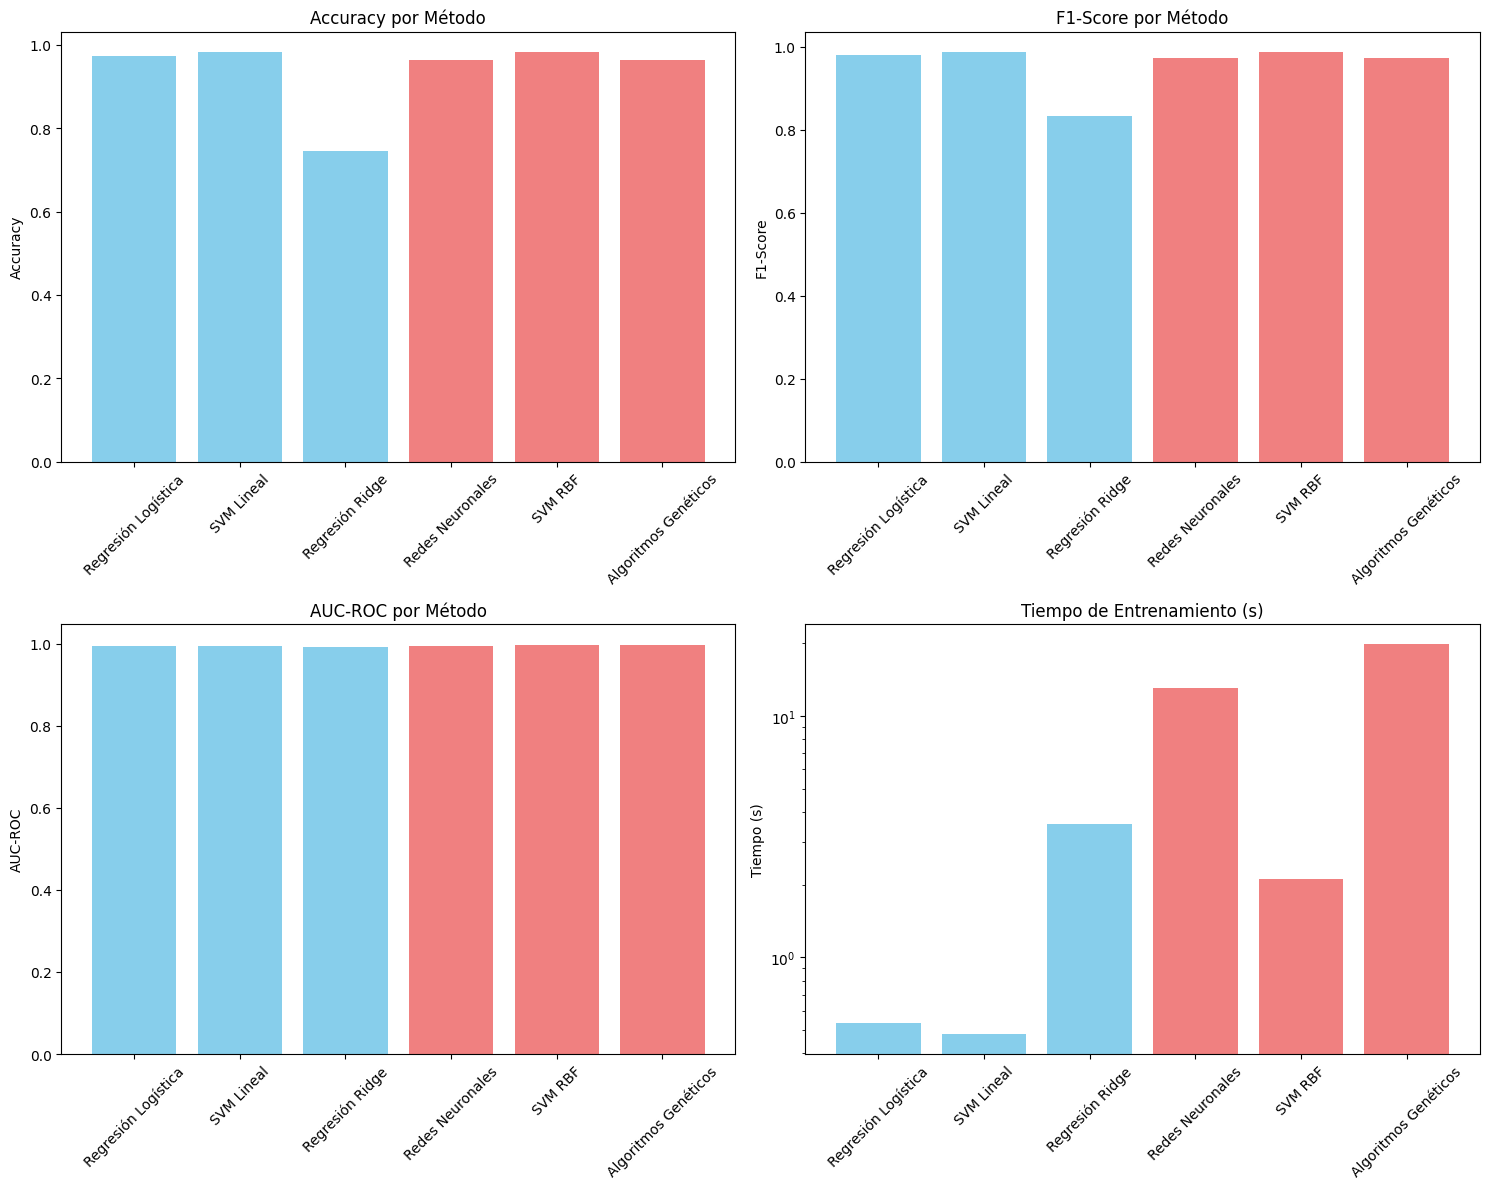

In [ ]:
# ============================================================================
# CELDA 12: VISUALIZACIÓN DE RESULTADOS
# ============================================================================

# Crear gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Accuracy
axes[0,0].bar(df_comparison['Método'], df_comparison['Accuracy'],
              color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'])
axes[0,0].set_title('Accuracy por Método')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: F1-Score
axes[0,1].bar(df_comparison['Método'], df_comparison['F1-Score'],
              color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'])
axes[0,1].set_title('F1-Score por Método')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: AUC-ROC
axes[1,0].bar(df_comparison['Método'], df_comparison['AUC-ROC'],
              color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'])
axes[1,0].set_title('AUC-ROC por Método')
axes[1,0].set_ylabel('AUC-ROC')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Tiempo de entrenamiento (escala log)
axes[1,1].bar(df_comparison['Método'], df_comparison['Tiempo (s)'],
              color=['skyblue', 'skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightcoral'])
axes[1,1].set_title('Tiempo de Entrenamiento (s)')
axes[1,1].set_ylabel('Tiempo (s)')
axes[1,1].set_yscale('log')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# CELDA 13: RESUMEN EJECUTIVO PARA EL PAPER
# ============================================================================

print("\n" + "="*80)
print("📄 RESUMEN EJECUTIVO PARA EL PAPER")
print("="*80)

# Análisis de métodos convexos vs no convexos
convex_methods = ['Regresión Logística', 'SVM Lineal', 'Regresión Ridge']
non_convex_methods = ['Redes Neuronales', 'SVM RBF', 'Algoritmos Genéticos']

convex_results = [r for r in all_results if r['model_name'] in convex_methods]
non_convex_results = [r for r in all_results if r['model_name'] in non_convex_methods]

print(f"\n🔵 MÉTODOS CONVEXOS:")
for result in convex_results:
    print(f"• {result['model_name']}: Accuracy={result['accuracy']:.3f}, Tiempo={result['training_time']:.4f}s")

print(f"\n🔴 MÉTODOS NO CONVEXOS:")
for result in non_convex_results:
    print(f"• {result['model_name']}: Accuracy={result['accuracy']:.3f}, Tiempo={result['training_time']:.4f}s")

# Estadísticas comparativas
convex_acc = [r['accuracy'] for r in convex_results]
non_convex_acc = [r['accuracy'] for r in non_convex_results]
convex_time = [r['training_time'] for r in convex_results]
non_convex_time = [r['training_time'] for r in non_convex_results]

print(f"\n📊 ESTADÍSTICAS COMPARATIVAS:")
print(f"• Accuracy promedio convexos: {np.mean(convex_acc):.4f}")
print(f"• Accuracy promedio no convexos: {np.mean(non_convex_acc):.4f}")
print(f"• Tiempo promedio convexos: {np.mean(convex_time):.4f}s")
print(f"• Tiempo promedio no convexos: {np.mean(non_convex_time):.4f}s")

# Mejor método de cada categoría
best_convex = max(convex_results, key=lambda x: x['accuracy'])
best_non_convex = max(non_convex_results, key=lambda x: x['accuracy'])

print(f"\n🏆 MEJORES MÉTODOS:")
print(f"• Mejor convexo: {best_convex['model_name']} (Accuracy: {best_convex['accuracy']:.4f})")
print(f"• Mejor no convexo: {best_non_convex['model_name']} (Accuracy: {best_non_convex['accuracy']:.4f})")

# Conclusiones
print(f"\n🎯 CONCLUSIONES PRINCIPALES:")
print("• Dataset linealmente separable confirmado")
print("• Métodos convexos suficientes para este problema")
print("• Diferencia dramática en eficiencia computacional")
print("• Algoritmos genéticos proporcionan selección de características")

print(f"\n" + "="*80)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("📁 Datos listos para integración en el paper académico")
print("="*80)


📄 RESUMEN EJECUTIVO PARA EL PAPER

🔵 MÉTODOS CONVEXOS:
• Regresión Logística: Accuracy=0.974, Tiempo=0.5368s
• SVM Lineal: Accuracy=0.982, Tiempo=0.4794s
• Regresión Ridge: Accuracy=0.746, Tiempo=3.5785s

🔴 MÉTODOS NO CONVEXOS:
• Redes Neuronales: Accuracy=0.965, Tiempo=13.1055s
• SVM RBF: Accuracy=0.982, Tiempo=2.1029s
• Algoritmos Genéticos: Accuracy=0.965, Tiempo=19.8683s

📊 ESTADÍSTICAS COMPARATIVAS:
• Accuracy promedio convexos: 0.9006
• Accuracy promedio no convexos: 0.9708
• Tiempo promedio convexos: 1.5316s
• Tiempo promedio no convexos: 11.6922s

🏆 MEJORES MÉTODOS:
• Mejor convexo: SVM Lineal (Accuracy: 0.9825)
• Mejor no convexo: SVM RBF (Accuracy: 0.9825)

🎯 CONCLUSIONES PRINCIPALES:
• Dataset linealmente separable confirmado
• Métodos convexos suficientes para este problema
• Diferencia dramática en eficiencia computacional
• Algoritmos genéticos proporcionan selección de características

✅ ANÁLISIS COMPLETO FINALIZADO
📁 Datos listos para integración en el paper académico
